# Import Necessary Headers

In [1]:
import pandas as pd
import numpy as np
import pickle
import shap
import xgboost as xgb
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

# Load Cleaned Master MIMIC-IV Dataset

In [2]:
# Cleaned Master MIMIC Data Set
df_master = pd.read_pickle('../MIMIC_IV/df_ckd_master_clean.pkl')
df_base = pd.read_pickle('../MIMIC_IV/df_ckd_base.pkl')

# Initial Preprocessing

In [4]:
# Drop unnecessary columns
drop_cols = [
    "anchor_year_group",
    "admittime_first",
    "dischtime_last",
    "hadm_id_last_CKD",
    "admittime_CKD",
    "dischtime_CKD", 
    'deathtime',
    "Creatinine_first_time",
    "Creatinine_last_time",
    "Creatinine_min_time",
    "Creatinine_max_time",
    "Creatinine_mean_time",
    "Creatinine_median_time"
]

df_master.drop(columns=drop_cols, axis=1, inplace=True)
df_master = df_master.drop(columns=df_master.filter(like="CKD_stage_last").columns)
df_master = df_master.drop(columns=df_master.filter(like="last_stage_icd").columns)
df_master = df_master.drop(columns=df_master.filter(like="last_long_title").columns)
df_master = df_master.drop(columns=df_master.filter(like='Chronic kidney disease').columns)
df_master = df_master.drop(columns=df_master.filter(like='chronic kidney disease').columns)
df_master = df_master.drop(columns=df_master.filter(like='End stage renal').columns)

# Convert Int64 columns to int64 for tensor compatibility
int64_columns = df_master.select_dtypes(include=['Int64']).columns
df_master[int64_columns] = df_master[int64_columns].astype('int64')

# Define Train and Test Data Splits

In [5]:
# Exclude response variable from features frame
X = df_master.drop('stage_delta', axis=1)

# Set response variable to stage_delta; binary CKD stage progression indicator 
y = df_master['stage_delta']

def create_splits(X, y, test_size=0.1, val_size=0.2, n_splits=5, seed=42):
    np.random.seed(seed)  # Ensure reproducibility
    
    # Split data into test and the remaining data
    X_traindev, X_test, y_traindev, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # Further split the remaining data into multiple train and validation sets
    val_sets = []
    for _ in range(n_splits):
        # Randomly select validation set from the remaining data
        X_train, X_val, y_train, y_val = train_test_split(X_traindev, y_traindev, test_size=val_size, random_state=np.random.randint(10000))
        
        val_sets.append({
            'X_train': X_train, 
            'y_train': y_train, 
            'X_val': X_val, 
            'y_val': y_val
        })

    return X_traindev, y_traindev, X_test, y_test, val_sets

X_traindev, y_traindev, X_test, y_test, val_sets = create_splits(X, y, test_size=0.2)

# Define XGBoost Classification Model

In [6]:
# Initialize classification model with GPU support
model = xgb.XGBClassifier(objective='binary:logistic', verbosity=0, tree_method='gpu_hist')

# Implement Bayesian Hyperparameter Optimization

In [7]:
# AUC evaluation function for validation sets
def AUC_validate(model, params, val_sets):
    auc_scores = []
    for val in val_sets:
        # Set parameters and reinitialize model to avoid leakage from previous fits
        params['tree_method'] = 'gpu_hist'  # Use GPU for training
        model.set_params(**params)
        model.fit(val['X_train'], val['y_train'])

        try:
            # Predict probabilities on the validation set and calculate AUC
            preds_proba = model.predict_proba(val['X_val'])[:, 1]  # Probability of the positive class
            auc = roc_auc_score(val['y_val'], preds_proba)
        except Exception as e:
            print(f"Error during model prediction: {str(e)}")
            auc = 0.0  # Consider the worst case if prediction fails

        auc_scores.append(auc)
    
    # Calculate average AUC across all validation sets
    return np.mean(auc_scores)

# Tune Classification Model Hyperparameters

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define the search space
auc_space = [
    Integer(5, 20, name='max_depth'),
    Integer(1, 10, name='min_child_weight'),
    Real(0.5, 3.0, name='gamma'),
    Real(0.6, 1.0, name='subsample'),
    Real(0.6, 1.0, name='colsample_bytree'),
    Real(0.01, 0.6, name='colsample_bylevel'),
    Real(0.01, 0.3, name='learning_rate'),
    Integer(50, 150, name='n_estimators')
]

# Define objective function
@use_named_args(auc_space)
def AUC_objective(**params):
    print("Testing params:", params)  # Print parameters to console
    auc = AUC_validate(model, params, val_sets)
    print("AUC for params:", auc)  # Print AUC for parameters console
    return -auc # Invert to optimize for minimum AUC 

# Perform Bayesian Optimization
result = gp_minimize(AUC_objective, auc_space, n_calls=10, random_state=42)
 
# Extract the best parameters and the corresponding score
best_auc_params = {dimension.name: result.x[i] for i, dimension in enumerate(auc_space)}
best_auc_score = -result.fun # Convert back to positive AUC

print("Best parameters found: ", best_auc_params)
print("Best average AUC across validation sets: ", best_auc_score)

Testing params: {'max_depth': 17, 'min_child_weight': 3, 'gamma': 2.449227500681924, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'colsample_bylevel': 0.06898520033262172, 'learning_rate': 0.1431821786701015, 'n_estimators': 83}
AUC for params: 0.9342329468637643
Testing params: {'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.6410289475677506, 'subsample': 0.88879950890673, 'colsample_bytree': 0.9754210836063002, 'colsample_bylevel': 0.010459471846198455, 'learning_rate': 0.29774135219445313, 'n_estimators': 112}
AUC for params: 0.9074154752828386
Testing params: {'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.5576560626035394, 'subsample': 0.8099098641033557, 'colsample_bytree': 0.7599443886861023, 'colsample_bylevel': 0.0375327412960331, 'learning_rate': 0.2923891004640232, 'n_estimators': 73}
AUC for params: 0.9185490324807434
Testing params: {'max_depth': 6, 'min_child_weight': 7, 'gamma': 1.456154978167907, 'subsample': 0.9932923543227153, 'colsa

# Train XG Boost Classifier on Full Training Set

In [9]:
# Train the XG Boost regressor model on the full training set with tuned hyperparameters
model.set_params(**best_auc_params)
model.fit(X_traindev, y_traindev)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5567287308183387, colsample_bynode=1,
              colsample_bytree=0.7580600944007259, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=2.6057119364874968, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.22090887879836207, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=14, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=83, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

# Evaluate Accuracy on Test Set

In [10]:
y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred)

print(f"Area Under ROC Curve: {auc}")

Area Under ROC Curve: 0.7746153137499264


# SHAP Explainer

In [11]:
# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for a set of data
shap_values = explainer.shap_values(X_test)

# Extract Top 40 SHAP Values

In [12]:
# List of feature names to remove
SHAP_feature_names = X.columns.tolist()
KFRE_feature_names = df_base.columns.tolist()  # replace with actual feature names

# Get the indices of the features to remove
KFRE_feat_indices = [SHAP_feature_names.index(feat) for feat in KFRE_feature_names if feat in SHAP_feature_names]

# Create a mask to keep only specified features
mask = np.ones(len(SHAP_feature_names), dtype=bool)
mask[KFRE_feat_indices] = False

# Apply the mask to shap_values and SHAP_feature_names
filtered_shap_values = shap_values[:, mask]
filtered_feature_names = [SHAP_feature_names[i] for i in range(len(SHAP_feature_names)) if mask[i]]

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.mean(np.abs(filtered_shap_values), axis=0)

# Sort SHAP indices, values, and feature names by mean absolute SHAP value
sorted_shap_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_shap_values = mean_abs_shap_values[sorted_shap_indices]
sorted_feature_names = np.array(filtered_feature_names)[sorted_shap_indices]

# Extract top 40 features
top_n = 40
top_shap_values = sorted_shap_values[:top_n]
XGboost40 = sorted_feature_names[:top_n]

# Plot Mean Absolute SHAP Values

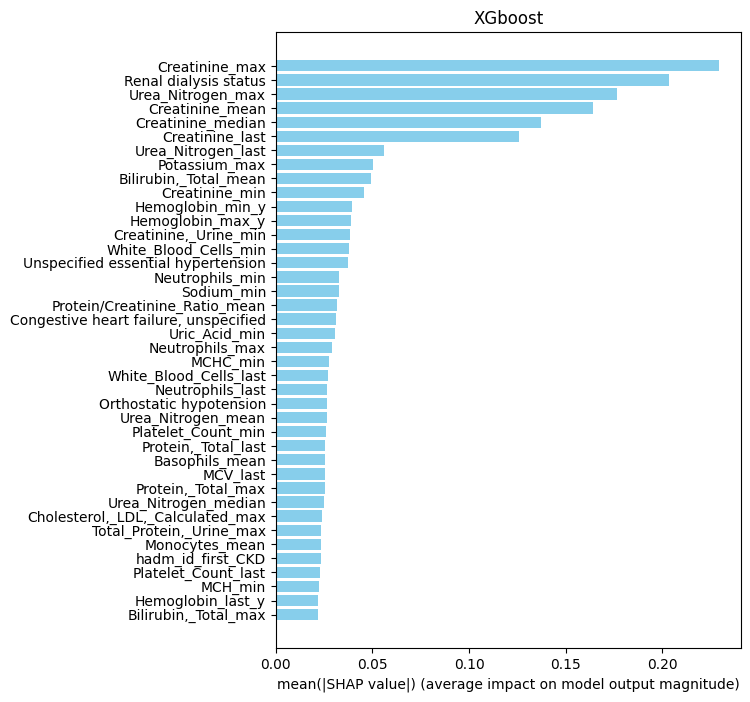

In [13]:
# Create a horizontal bar plot
plt.figure(figsize=(6, 8))
plt.barh(XGboost40[::-1], top_shap_values[::-1], color='skyblue')
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
plt.title('XGboost')

# Save the plot as a PNG file
plt.savefig("XGboostSHAP.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# SHAP Summary Plot

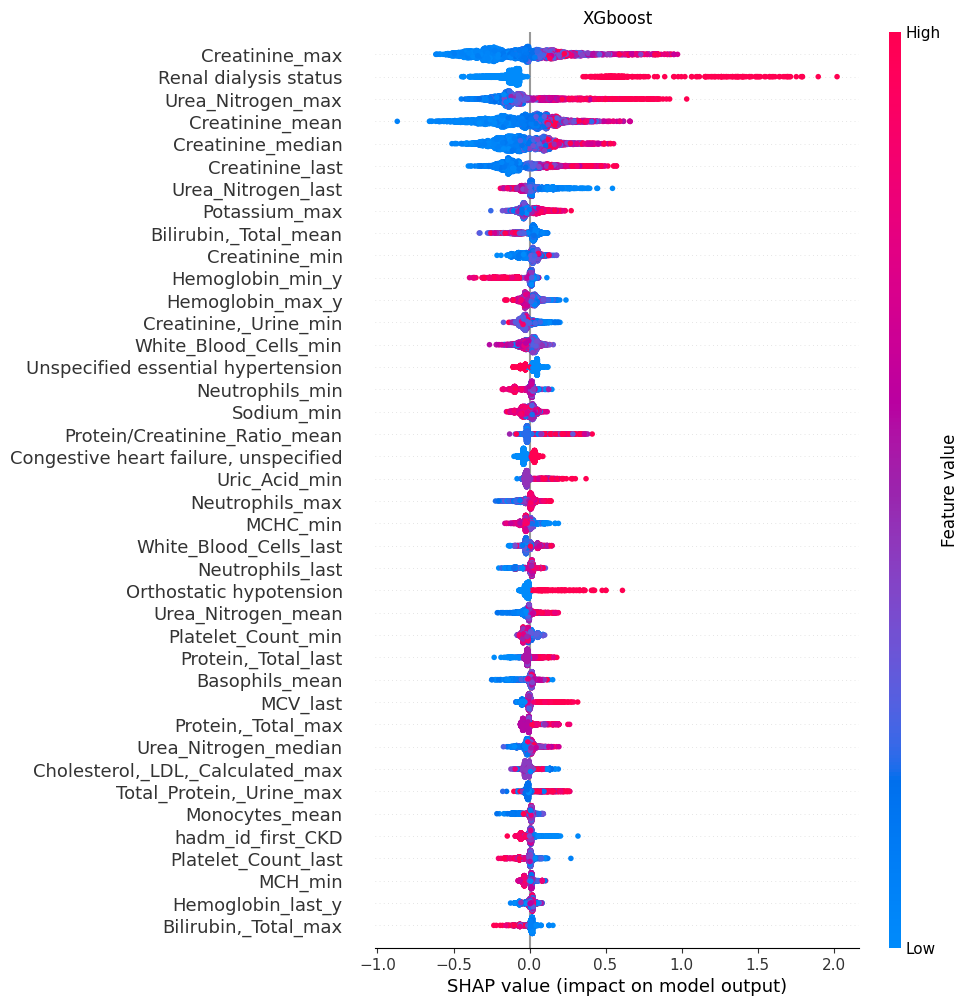

In [14]:
# Create a mask to select only the top 40 features
top_40_mask = np.isin(filtered_feature_names, XGboost40)

# Filter the SHAP values and feature names to keep only the top 40 features
top_40_shap_values = filtered_shap_values[:, top_40_mask]
top_40_feature_names = np.array(filtered_feature_names)[top_40_mask]

# Filter the X_test DataFrame to only include the top 40 features
X_test_top_40 = X_test.loc[:, top_40_feature_names]

plt.figure(figsize=(9, 8))

# Create the summary plot with the top 40 features
shap.summary_plot(
    top_40_shap_values, 
    X_test_top_40,
    feature_names=top_40_feature_names, 
    plot_size=(10, 10), 
    max_display=40,
    show=False
)

# Customize plot appearance
plt.title('XGboost')
plt.xlabel('SHAP value (impact on model output)')

# Save the plot as a PNG file
plt.savefig("XGboostBeeswarm.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Write Top 40 Features List to Pickle File

In [15]:
# Save the list to a pickle file
with open('XGboost40.pkl', 'wb') as f:
    pickle.dump(list(XGboost40), f)